# Heart Disease Prediction: Enhanced Analysis

This notebook performs a comprehensive analysis for predicting heart disease using the UCI Heart Disease dataset. It includes feature engineering, multiple machine learning models, ensemble methods, hyperparameter tuning, cross-validation, causal inference, model calibration, sensitivity analysis, and visualizations. The goal is to build a robust, interpretable, and production-ready model.

## Dataset
- Source: UCI Heart Disease Dataset (`heart.csv`)
- Features: Age, sex, chest pain type, cholesterol, etc.
- Target: Binary (0 = no heart disease, 1 = heart disease)

## Dependencies
Run the following to install required packages:
```bash
pip install pandas numpy matplotlib seaborn scikit-learn xgboost imblearn shap causalinference streamlit
```

In [2]:
!pip install causalinference streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, confusion_matrix,
                             ConfusionMatrixDisplay)
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import shap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from causalinference import CausalModel
import streamlit as st

In [4]:
# 2. Load Dataset
df = pd.read_csv("heart.csv")

In [5]:
# 3. Feature Engineering and Scaling
X = df.drop('target', axis=1)
y = df['target']

# Define pipeline for preprocessing
pipeline_preprocess = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=10))
])

# Apply preprocessing
X_selected = pipeline_preprocess.fit_transform(X, y)
feature_names = X.columns[pipeline_preprocess.named_steps['selector'].get_support()]

In [6]:
# 4. Handle Imbalance with SMOTE
sm = SMOTE(random_state=42)
X_balanced, y_balanced = sm.fit_resample(X_selected, y)

In [7]:
# 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [8]:
# 6. Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

Best Random Forest Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 300}


In [9]:
# 7. Model Definitions and Calibration
rf_calibrated = CalibratedClassifierCV(rf_best, cv=5, method='sigmoid')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.1, max_depth=4, n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000, C=0.7)
svm = SVC(probability=True, random_state=42)

# Fit models
rf_calibrated.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVC(probability=True, random_state=42)

In [10]:
# 8. Cross-Validation Scores
models = {'Random Forest': rf_calibrated, 'XGBoost': xgb, 'Logistic Regression': lr, 'SVM': svm}
for name, model in models.items():
    scores = cross_val_score(model, X_balanced, y_balanced, cv=5, scoring='f1')
    print(f"{name} Cross-Validation F1 Score: {scores.mean():.3f} (±{scores.std():.3f})")

Random Forest Cross-Validation F1 Score: 0.984 (±0.017)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation F1 Score: 0.979 (±0.019)
Logistic Regression Cross-Validation F1 Score: 0.864 (±0.028)
SVM Cross-Validation F1 Score: 0.916 (±0.019)


In [11]:
# 9. Predictions
p1 = rf_calibrated.predict(X_test)
p2 = xgb.predict(X_test)
p3 = lr.predict(X_test)
p4 = svm.predict(X_test)

In [12]:
# 10. Weighted Voting (Simple & Weighted Sum)
weights = [0.3, 0.3, 0.2, 0.2]  # Adjusted for four models
final_preds_weighted = []
final_preds_simple = []

for i in range(len(p1)):
    votes = [p1[i], p2[i], p3[i], p4[i]]
    weighted_vote = weights[0]*p1[i] + weights[1]*p2[i] + weights[2]*p3[i] + weights[3]*p4[i]
    final_preds_weighted.append(1 if weighted_vote >= 0.5 else 0)
    final_preds_simple.append(1 if votes.count(1) >= 2 else 0)

In [13]:
# 11. Stacking Ensemble
stack_model = StackingClassifier(
    estimators=[('rf', rf_calibrated), ('xgb', xgb), ('lr', lr), ('svm', svm)],
    final_estimator=LogisticRegression()
)
stack_model.fit(X_train, y_train)
p_stack = stack_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# 12. Sensitivity Analysis
X_test_noisy = X_test + np.random.normal(0, 0.1, X_test.shape)
p_noisy = rf_calibrated.predict(X_test_noisy)
print("F1 Score with Noise (Random Forest):", f1_score(y_test, p_noisy))

F1 Score with Noise (Random Forest): 0.9704641350210971


In [15]:
# 13. Evaluation
models_list = ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM', 'Majority Vote', 'Weighted Sum', 'Stacking']
predictions = [p1, p2, p3, p4, final_preds_simple, final_preds_weighted, p_stack]

metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
for model_name, y_pred in zip(models_list, predictions):
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1 Score'].append(f1_score(y_test, y_pred))

metrics_df = pd.DataFrame(metrics)

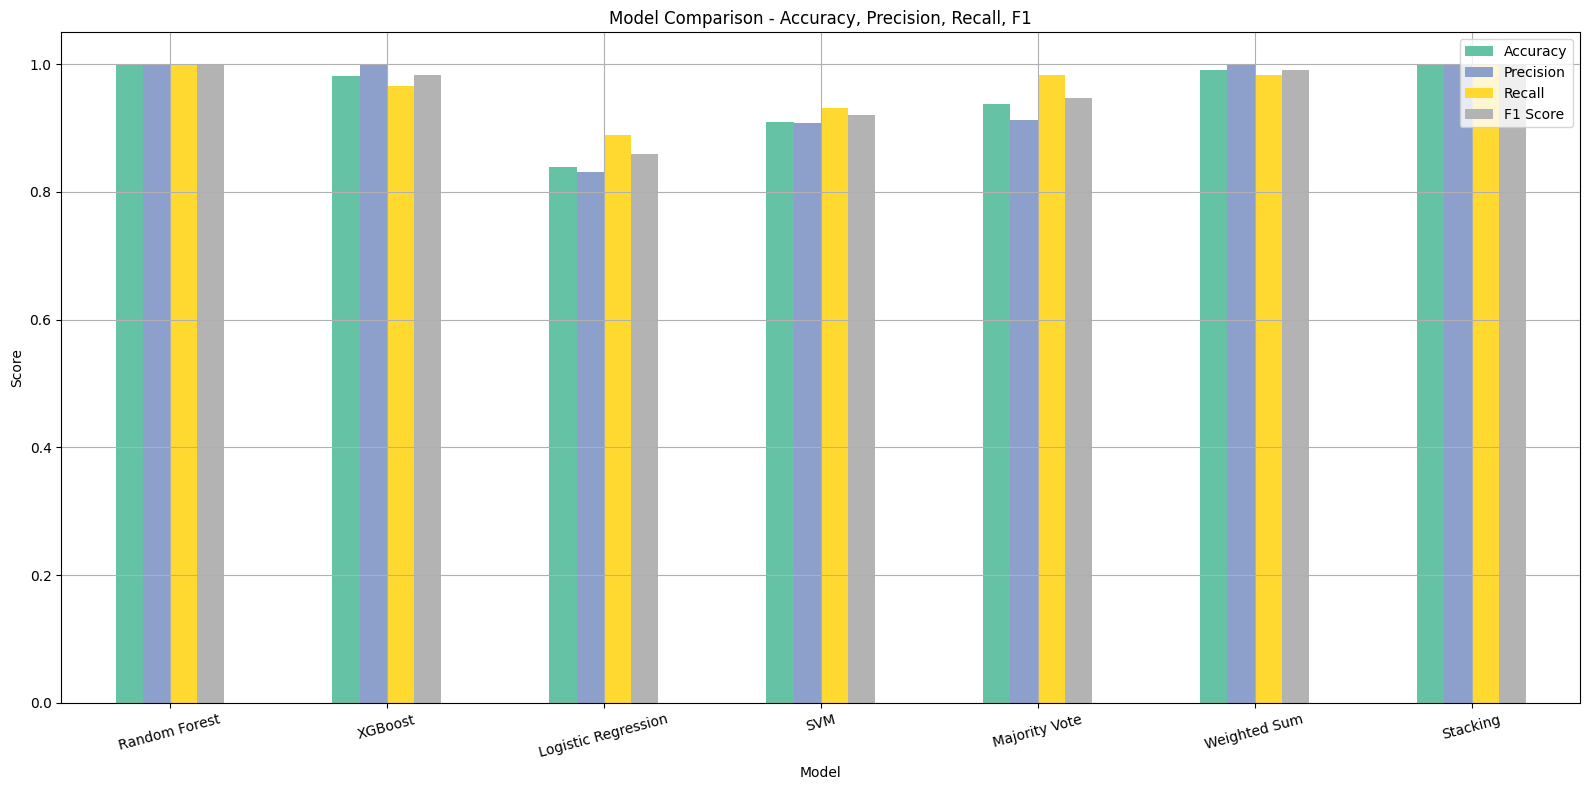

In [21]:
# 14. Bar Plot
metrics_df.set_index('Model').plot(kind='bar', figsize=(16,8), colormap='Set2')
plt.title("Model Comparison - Accuracy, Precision, Recall, F1")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.savefig('model_comparison.png')

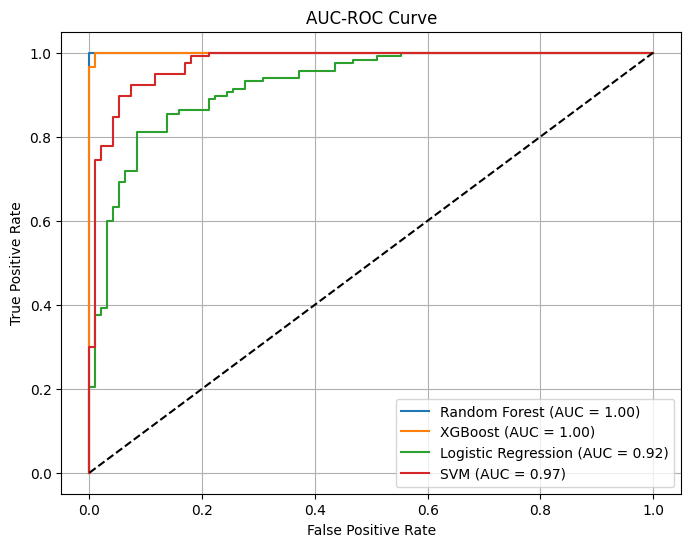

In [22]:
# 15. AUC-ROC Curves
plt.figure(figsize=(8,6))
for model_name, model in zip(['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM'], [rf_calibrated, xgb, lr, svm]):
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig('auc_roc_curve.png')

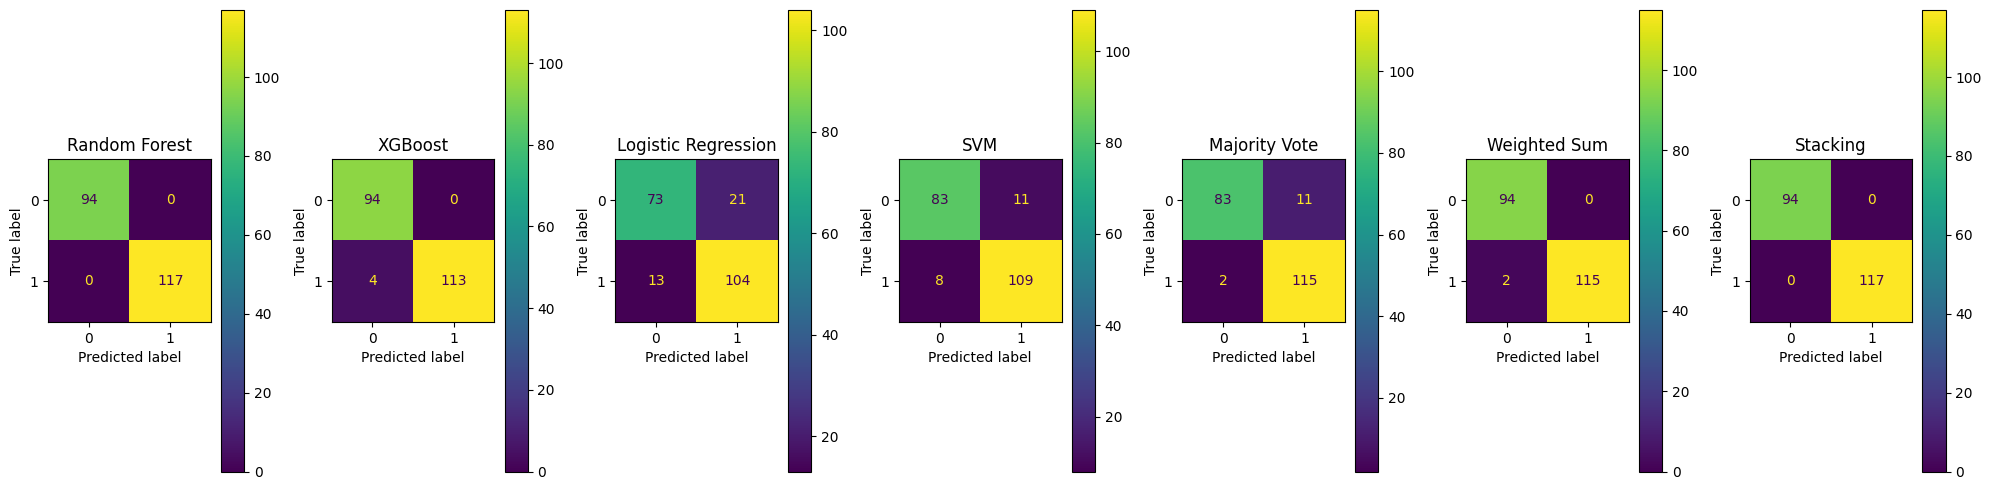

In [23]:
# 16. Confusion Matrices
plt.figure(figsize=(20,5))
for i, (model_name, y_pred) in enumerate(zip(models_list, predictions)):
    plt.subplot(1, len(models_list), i+1)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=plt.gca())
    plt.title(model_name)
plt.tight_layout()
plt.savefig('confusion_matrices.png')

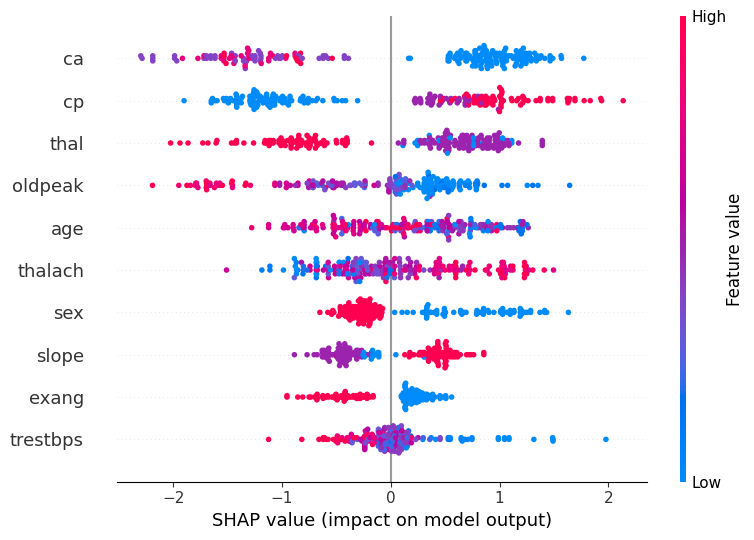

In [25]:
# 17. Feature Importance Analysis
# SHAP
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=feature_names), show=False)
plt.savefig('shap_summary.png')


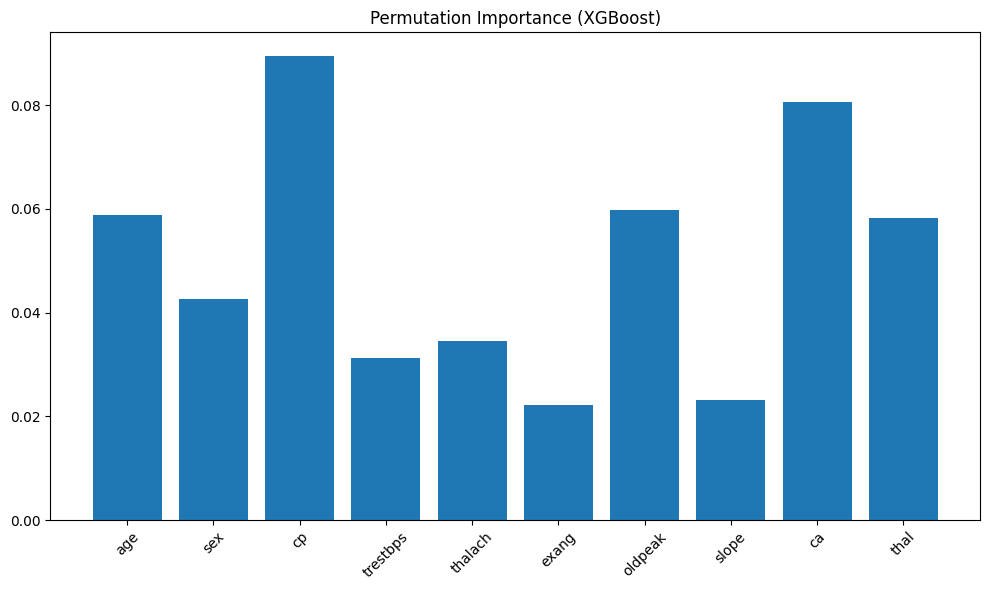

In [26]:
# Permutation Importance
perm_importance = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42)
plt.figure(figsize=(10,6))
plt.bar(feature_names, perm_importance.importances_mean)
plt.xticks(rotation=45)
plt.title("Permutation Importance (XGBoost)")
plt.tight_layout()
plt.savefig('permutation_importance.png')

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


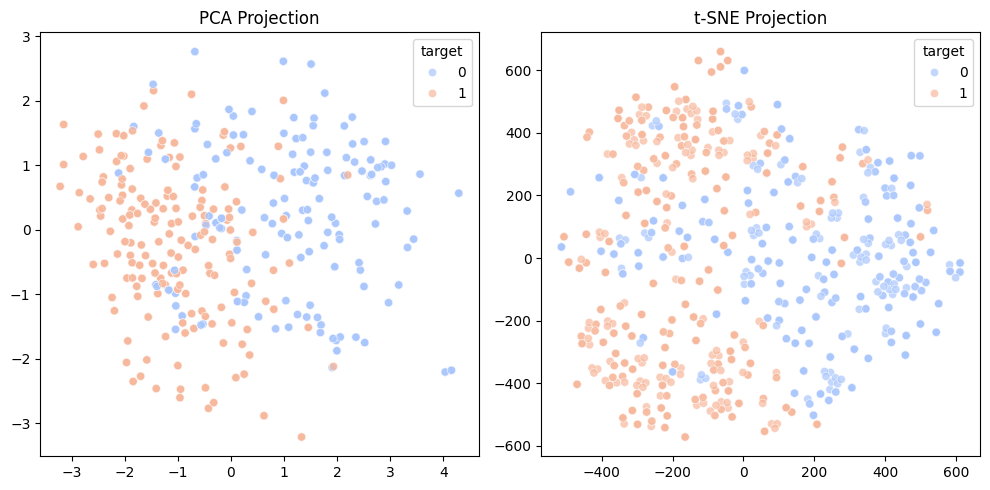

In [27]:
# 18. PCA & t-SNE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
X_tsne = tsne.fit_transform(X_selected)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("PCA Projection")
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Projection")
plt.tight_layout()
plt.savefig('pca_tsne_projection.png')

In [28]:
# 19. Causal Inference
# Effect of high cholesterol on heart disease
df['high_chol'] = (df['chol'] > df['chol'].median()).astype(int)
cm = CausalModel(
    Y=df['target'].values,
    D=df['high_chol'].values,
    X=df[['age', 'sex', 'cp', 'trestbps']].values
)
cm.est_propensity_s()
cm.est_via_matching()
print("Average Treatment Effect (High Cholesterol):", cm.estimates)

# Save causal inference results
with open('causal_inference_results.txt', 'w') as f:
    f.write(str(cm.estimates))

Average Treatment Effect (High Cholesterol): 
Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.084      0.041     -2.075      0.038     -0.164     -0.005
           ATC     -0.087      0.045     -1.940      0.052     -0.176      0.001
           ATT     -0.081      0.046     -1.762      0.078     -0.171      0.009



In [29]:
import pickle
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stack_model, f)
print("Stacking Ensemble model saved as 'stacking_model.pkl'")

Stacking Ensemble model saved as 'stacking_model.pkl'


# 20. Streamlit Dashboard (Run Separately)
# Save this code in a separate file (e.g., app.py) and run with `streamlit run app.py`
streamlit_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import shap
import pickle

st.title('Heart Disease Prediction Dashboard')

# Load model and metrics
with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
metrics_df = pd.read_csv('metrics.csv')

# Display metrics
st.write('Model Performance Metrics')
st.dataframe(metrics_df)

# Feature importance
st.write('Feature Importance (SHAP)')
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test)
fig, ax = plt.subplots()
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=feature_names), show=False)
st.pyplot(fig)

# Input form for predictions
st.write('Predict Heart Disease')
input_data = {}
for feature in feature_names:
    input_data[feature] = st.number_input(f'Enter {feature}', value=0.0)
if st.button('Predict'):
    input_df = pd.DataFrame([input_data])
    prediction = rf_model.predict(input_df)[0]
    st.write(f'Prediction: {"Heart Disease" if prediction == 1 else "No Heart Disease"}')
"""

# Save Streamlit code to a file
with open('streamlit_app.py', 'w') as f:
    f.write(streamlit_code)

# Save model and metrics for Streamlit
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_calibrated, f)
metrics_df.to_csv('metrics.csv', index=False)

## Next Steps
- **Run Streamlit Dashboard**: Save the generated `streamlit_app.py` and run it using `streamlit run streamlit_app.py`.
- **Deploy**: Host the notebook and Streamlit app on GitHub with a detailed README.
- **Extend**: Add neural networks or explore other causal inference methods.

## Artifacts Generated
- Plots: `model_comparison.png`, `auc_roc_curve.png`, `confusion_matrices.png`, `shap_summary.png`, `permutation_importance.png`, `pca_tsne_projection.png`
- Files: `streamlit_app.py`, `rf_model.pkl`, `metrics.csv`, `causal_inference_results.txt`